# Predicting System Availability with Monte Carlo Simulations
This Python script conducts Monte Carlo simulations to predict system availability based on provided data.

## JSON Data Files
To run the simulations, ensure that the following JSON files are located in the same directory as this notebook.

### components.json
This file contains information about the system components. It consists of two arrays: one containing the names of the components and the other their respective availabilities.

For example, for two components:
```
{
    "name": ["Azure Active Directory B2C", "CosmosDb" ],
    "availability": ["0.9999", "0.9999"]       
}
```

### maintenance.json
This file provides information about scheduled maintenance periods. It includes three arrays:

1. Maintenance names
2. Start time of the scheduled maintenance in the format '%d.%m.%Y %H:%M', e.g., '1.3.2024 9:00'
3. Duration of the maintenance in hours

For example:
```
{
    "name": ["IoT Edge H1", "IoT Edge H2"],
    "start": ["1.3.2024 9:00", "1.9.2024 9:00"],
    "duration": ["5","5"]
}
```

By organizing the data in this manner, the script can effectively conduct availability predictions through Monte Carlo simulations.

In [36]:
import pandas as pd
import array as arr
import random
import numpy as np
import datetime


try :
    components_df = pd.read_json('components.json')
    print(components_df.to_string()) 
except Exception as error:
  print("An error occurred:", error)  
  exit()  

try :
    maintenance_df = pd.read_json('maintenance.json')
    print(maintenance_df.to_string()) 
except Exception as error:
  print("An error occurred:", error)  
  exit()    

                         name  availability
0  Azure Active Directory B2C        0.9999
1                    CosmosDb        0.9999
2                  PostgreSQL        0.9990
3                     IoT Hub        0.9990
4                 App Service        0.9995
5                          VM        0.9990
6                         VM2        0.9990
7    Azure Container Registry        0.9990
8            Storage accounts        0.9990
9           Azure NAT Gateway        0.9999
          name           start  duration
0  IoT Edge H1   1.3.2024 9:00         5
1  IoT Edge H2   1.9.2024 9:00         5
2      Site H1   1.4.2024 9:00        48
3      Site H2  1.10.2024 9:00        48


Calculating the yearly hours of downtime based on the availability.

In [37]:

components_df = components_df.astype({"availability": float})

components_df["hours"] = np.ceil( 8760  * (1 - components_df["availability"]))
print(components_df.to_string()) 

                         name  availability  hours
0  Azure Active Directory B2C        0.9999    1.0
1                    CosmosDb        0.9999    1.0
2                  PostgreSQL        0.9990    9.0
3                     IoT Hub        0.9990    9.0
4                 App Service        0.9995    5.0
5                          VM        0.9990    9.0
6                         VM2        0.9990    9.0
7    Azure Container Registry        0.9990    9.0
8            Storage accounts        0.9990    9.0
9           Azure NAT Gateway        0.9999    1.0


First converting the start date, to date format from a string and then calculate the hour of the year and place the result to a new column, "start_hours".

In [38]:
format_str = '%d.%m.%Y %H:%M'

maintenance_df['start'] = pd.to_datetime(maintenance_df['start'], format='%d.%m.%Y %H:%M')
maintenance_df['start_hours'] = (maintenance_df['start'] - pd.Timestamp(year=maintenance_df['start'].dt.year[0], month=1, day=1)).dt.total_seconds() / 3600
maintenance_df['start_hours'] = maintenance_df['start_hours'].astype(int)

print(maintenance_df.to_string())

maintenance_hours = arr.array('l')
for i in range(0, len(maintenance_df)):
    for j in range(0, maintenance_df.iat[i,2]):
        maintenance_hours.append(maintenance_df.iat[i,3]+j)
maintenance_hours = sorted(maintenance_hours)
print(maintenance_hours)

          name               start  duration  start_hours
0  IoT Edge H1 2024-03-01 09:00:00         5         1449
1  IoT Edge H2 2024-09-01 09:00:00         5         5865
2      Site H1 2024-04-01 09:00:00        48         2193
3      Site H2 2024-10-01 09:00:00        48         6585
[1449, 1450, 1451, 1452, 1453, 2193, 2194, 2195, 2196, 2197, 2198, 2199, 2200, 2201, 2202, 2203, 2204, 2205, 2206, 2207, 2208, 2209, 2210, 2211, 2212, 2213, 2214, 2215, 2216, 2217, 2218, 2219, 2220, 2221, 2222, 2223, 2224, 2225, 2226, 2227, 2228, 2229, 2230, 2231, 2232, 2233, 2234, 2235, 2236, 2237, 2238, 2239, 2240, 5865, 5866, 5867, 5868, 5869, 6585, 6586, 6587, 6588, 6589, 6590, 6591, 6592, 6593, 6594, 6595, 6596, 6597, 6598, 6599, 6600, 6601, 6602, 6603, 6604, 6605, 6606, 6607, 6608, 6609, 6610, 6611, 6612, 6613, 6614, 6615, 6616, 6617, 6618, 6619, 6620, 6621, 6622, 6623, 6624, 6625, 6626, 6627, 6628, 6629, 6630, 6631, 6632]


Creating an empty dataframe for the results.

In [39]:
results_df = pd.DataFrame({
                   "hours": range(1, 8761)})

## Monte Carlo Simulations

The number of simulations can be set by the simulation_no variable.
Each simulation inserts maintenance period and random downtime hours, based on the provided availability data into a timeseries, which represents the downtimes during the whole year.

In [40]:
simulation_no = 100
max_downtime_at_a_time = 24
availability_limit = np.ceil(8760 * 0.98)
availability_limit_max = 0
availability_limit_min = 8760
availability_yearly_max = 0
availability_yearly_min = 8760
total_hours = int(components_df["hours"].sum())
print#(total_hours)
for s in range(0, simulation_no):
    results_df["Simulation "+str(s)] = 8760
    down_hours_full = arr.array('l')
    
    for c in range(0, len(components_df)):
        hours = int(components_df.iat[c,2])
        if(hours==1):
            down_hours_full.append(random.randrange(8761))        
        else:            
            for i in range(0, hours):
                # the random can return 0, because the given availibility is a limit
                # so the simulation runs within that
                if(hours > max_downtime_at_a_time):
                    period = random.randrange(max_downtime_at_a_time)
                else:
                    period = random.randrange(hours)
                start = random.randrange(8761-period)
                for p in range(0, period):
                    down_hours_full.append(start+p)
                if(period == 0):
                    # if the period is 0 the hour is still skipped it means
                    # that the availability is better than given
                    hours = hours - 1
                else:            
                    hours = hours - period
                if(hours == 0):
                    break
    down_hours_full = sorted(down_hours_full)
    down_hours = arr.array('l')
    [down_hours.append(item) for item in down_hours_full if item not in down_hours]
    down_hours_index = 0
    maintenance_hours_index = 0
    down_hours_temp = 0
    for i in range(0, 8760):
        if ( maintenance_hours_index < len(maintenance_hours) ) and ( i == maintenance_hours[maintenance_hours_index]):
                down_hours_temp += 1
                maintenance_hours_index += 1
                if ( down_hours_index < len(down_hours) ) and ( i == down_hours[down_hours_index]):
                    down_hours_index += 1
        else:
            if ( down_hours_index < len(down_hours) ) and ( i == down_hours[down_hours_index]):
                down_hours_temp += 1
                down_hours_index += 1
        if down_hours_temp > 0:    
            results_df.iat[i,s+1] = results_df.iat[i,s+1] - down_hours_temp
            if results_df.iat[i,s+1] == availability_limit:
                if i < availability_limit_min:
                    availability_limit_min = i
                if i > availability_limit_max:
                    availability_limit_max = i
    if ( availability_yearly_max < results_df.iat[8759,s+1] ):
        availability_yearly_max = results_df.iat[8759,s+1]
    if ( availability_yearly_min > results_df.iat[8759,s+1] ):
        availability_yearly_min = results_df.iat[8759,s+1]
        
print(availability_yearly_min)
print(availability_yearly_max)
                                
print(availability_limit_min)
print(availability_limit_max)



8600
8617
8760
0


/var/folders/pb/cg3vh5v15fzc5km3j239kxxr0000gn/T/ipykernel_38115/2620580919.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results_df["Simulation "+str(s)] = 8760


The results are ploted so that each line represents one simulation and shows how the downtime increases during the year passing the 98% line which has defined by the SLA contract.

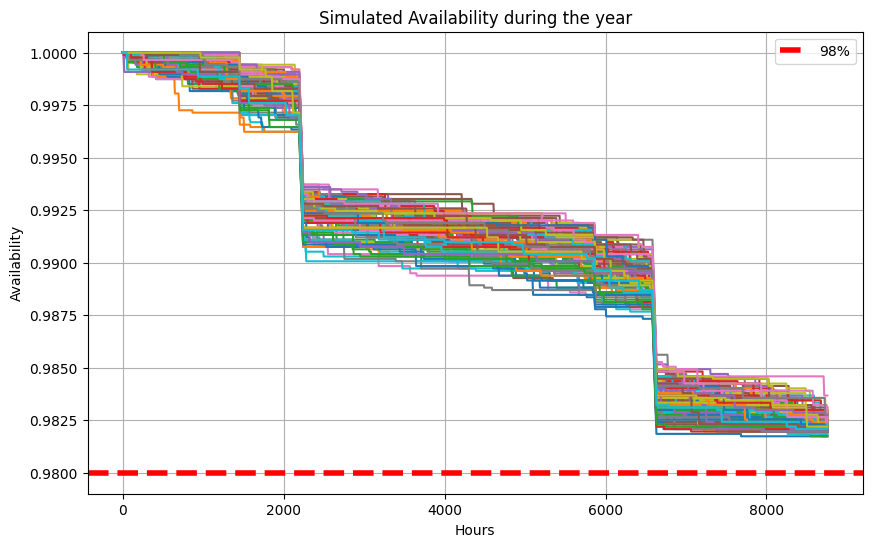

In [41]:
import matplotlib.pyplot as plt

# prepare the data
results_df = results_df.drop('hours', axis=1)
for s in range(0, simulation_no):
    results_df["Simulation "+str(s)] = results_df["Simulation "+str(s)] / 8760

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(results_df) 
plt.gca().set_prop_cycle(None)
plt.plot([], [])  
plt.title('Simulated Availability during the year')
plt.xlabel('Hours')
plt.ylabel('Availability')
plt.grid(True)
# Draw a horizontal red line at 98%
plt.axhline(y=0.98, color='red', linestyle='--', linewidth=4, label='98%')
plt.legend()
plt.show()


The second plot zooms into an area and shows the simulation earliest and latest passing the 98% line.

In [42]:
if (availability_yearly_min < 0.98):
    start_of_year = datetime.datetime(year=datetime.datetime.now().year, month=1, day=1)
    availability_limit_min_date = start_of_year + datetime.timedelta(hours=availability_limit_min)
    availability_limit_max_date = start_of_year + datetime.timedelta(hours=availability_limit_max)

    # Plotting the data
    plt.figure(figsize=(10, 6))
    plt.plot(results_df)
    plt.gca().set_prop_cycle(None) 
    plt.plot([], [])
    plt.title('Simulated Availability during the year breaking the 98% limit')
    plt.xlabel('Hours')
    plt.ylabel('Availability')
    plt.grid(True)
    # Draw a horizontal red line at 98%
    plt.axhline(y=0.98, color='red', linestyle='--', linewidth=4, label='98%')
    plt.axvline(x=availability_limit_min, color='yellow', linestyle='--', linewidth=2, label="At "+ str(availability_limit_min_date) + " reaching the 98% earliest")
    plt.axvline(x=availability_limit_max, color='green', linestyle='--', linewidth=2, label="At "+ str(availability_limit_max_date) + " reaching the 98% latest")
    plt.legend()
    # Set limits to zoom into a certain area
    plt.xlim(availability_limit_min-200, availability_limit_max+200)  # Adjust the limits of the x-axis
    plt.ylim(0.97, 0.99)  # Adjust the limits of the y-axis
    plt.show()


Third plot shows how the availibility ends at the end of the year.

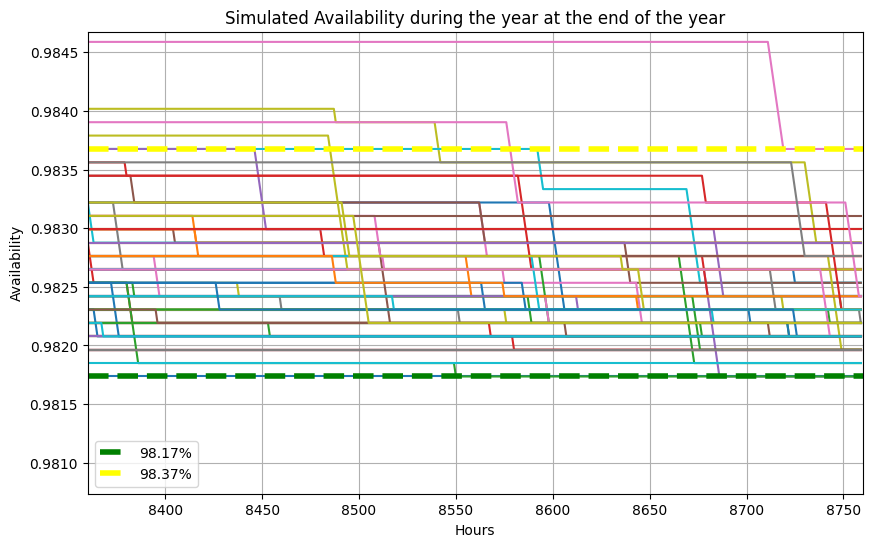

In [43]:
availability_yearly_min = availability_yearly_min / 8760
availability_yearly_max = availability_yearly_max / 8760

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(results_df)
plt.gca().set_prop_cycle(None) 
plt.plot([], [])
plt.title('Simulated Availability during the year at the end of the year')
plt.xlabel('Hours')
plt.ylabel('Availability')
plt.grid(True)
# Draw a horizontal red line at 98%
plt.axhline(y=availability_yearly_min, color='green', linestyle='--', linewidth=4, label=str(round(availability_yearly_min * 100, 2))+'%')
plt.axhline(y=availability_yearly_max, color='yellow', linestyle='--', linewidth=4, label=str(round(availability_yearly_max * 100, 2))+'%')
plt.legend()
# Set limits to zoom into a certain area
plt.xlim(8360, 8760)  # Adjust the limits of the x-axis
plt.ylim(availability_yearly_min - 0.001, availability_yearly_max + 0.001)  # Adjust the limits of the y-axis
plt.show()
